<a href="https://colab.research.google.com/github/erick-arango/Proyecto_Introduccion_IA/blob/main/02_preprocesado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Entrega 2 — Preprocesamiento de Datos  
**Proyecto AI4ENG UDEA 2025-2 – Pruebas Saber Pro Colombia**

En este notebook se realiza la segunda fase del proyecto:  
**limpieza, imputación, codificación y normalización de datos** del archivo `train.csv` de la competencia.

---

**Objetivo:** Dejar el dataset listo para la etapa de modelado (Entrega 3).  
**Nota:** Este notebook no genera archivos de salida; el preprocesamiento se usa solo en el entorno local o de Kaggle.

In [36]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Verificando archivo de datos...")
if not os.path.exists("train.csv"):
    raise FileNotFoundError("No se encontró train.csv. Sube el archivo antes de continuar.")
else:
    print("train.csv encontrado correctamente.")


Verificando archivo de datos...
train.csv encontrado correctamente.


##2. Exploración inicial del dataset

En esta etapa se cargan los datos, se verifica su tamaño, las columnas y la cantidad de valores faltantes
para comprender la estructura general del conjunto de entrenamiento.


In [37]:
z = pd.read_csv("train.csv")
print(f"Shape original: {z.shape}")
print(f"Columnas disponibles ({len(z.columns)}):\n{list(z.columns)}\n")

print("Resumen de valores faltantes (top 10):")
display(z.isna().sum().sort_values(ascending=False).head(10))

print("\nTipos de datos presentes:")
display(z.dtypes.value_counts())


Shape original: (692500, 21)
Columnas disponibles (21):
['ID', 'PERIODO_ACADEMICO', 'E_PRGM_ACADEMICO', 'E_PRGM_DEPARTAMENTO', 'E_VALORMATRICULAUNIVERSIDAD', 'E_HORASSEMANATRABAJA', 'F_ESTRATOVIVIENDA', 'F_TIENEINTERNET', 'F_EDUCACIONPADRE', 'F_TIENELAVADORA', 'F_TIENEAUTOMOVIL', 'E_PRIVADO_LIBERTAD', 'E_PAGOMATRICULAPROPIO', 'F_TIENECOMPUTADOR', 'F_TIENEINTERNET.1', 'F_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL', 'INDICADOR_1', 'INDICADOR_2', 'INDICADOR_3', 'INDICADOR_4']

Resumen de valores faltantes (top 10):


,0
F_TIENEAUTOMOVIL,43623
F_TIENELAVADORA,39773
F_TIENECOMPUTADOR,38103
F_ESTRATOVIVIENDA,32137
E_HORASSEMANATRABAJA,30857
F_TIENEINTERNET.1,26629
F_TIENEINTERNET,26629
F_EDUCACIONMADRE,23664
F_EDUCACIONPADRE,23178
E_PAGOMATRICULAPROPIO,6498



Tipos de datos presentes:


,count
object,15
float64,4
int64,2


##3. Limpieza e imputación de datos  

En esta sección se corrigen los valores faltantes y se unifican categorías inconsistentes.  
La imputación se realiza con:
- **Mediana** para variables numéricas  
- **Moda** para variables categóricas  

También se aplican reglas específicas a variables clave del contexto educativo.


In [38]:
z = z.copy()

# --- Tratamiento especial para columna de matrícula universitaria ---
if 'E_VALORMATRICULAUNIVERSIDAD' in z.columns:
    cmap = {
        'Entre 1 millón y menos de 2.5 millones': 1.75,
        'Entre 2.5 millones y menos de 4 millones': 3.25,
        'Menos de 500 mil': 0.25,
        'Entre 500 mil y menos de 1 millón': 0.75,
        'Entre 4 millones y menos de 5.5 millones': 4.75,
        'Más de 7 millones': 7.75,
        'Entre 5.5 millones y menos de 7 millones': 6.25,
        'No pagó matrícula': 0,
        'no info': -1
    }
    z['E_VALORMATRICULAUNIVERSIDAD'] = z['E_VALORMATRICULAUNIVERSIDAD'].fillna('no info')
    z['E_VALORMATRICULAUNIVERSIDAD_num'] = z['E_VALORMATRICULAUNIVERSIDAD'].map(lambda x: cmap.get(x, -1))

# --- Limpieza general de categorías ---
for col in z.columns:
    if z[col].dtype == object:
        z[col] = z[col].replace({'No sabe': 'no info', 'No Aplica': 'no info'})

# --- Imputación por tipo ---
for col in z.select_dtypes(include=[np.number]).columns:
    z[col] = z[col].fillna(z[col].median())

for col in z.select_dtypes(include=['object']).columns:
    moda = z[col].mode().iloc[0] if not z[col].mode().empty else 'no info'
    z[col] = z[col].fillna(moda)

print("Imputación completada. Nulos restantes:", z.isna().sum().sum())


Imputación completada. Nulos restantes: 0


##  4. Codificación de variables categóricas  

Se aplican dos tipos de codificación:  
- **One-Hot Encoding:** variables con ≤ 12 categorías (genera nuevas columnas binarias).  
- **Label Encoding:** variables con muchas categorías (asigna un número único a cada valor).


In [39]:
cat_cols = z.select_dtypes(include=['object']).columns
onehot_cols = [c for c in cat_cols if z[c].nunique() <= 12]
label_cols  = [c for c in cat_cols if z[c].nunique() > 12]

print(f"One-Hot Encoding en {len(onehot_cols)} columnas | Label Encoding en {len(label_cols)}.\n")

# One-Hot Encoding
z = pd.get_dummies(z, columns=onehot_cols, dtype=int)

# Label Encoding
for c in label_cols:
    z[c] = LabelEncoder().fit_transform(z[c].astype(str))

print(f"Codificación completada. Nuevo shape: {z.shape}")


One-Hot Encoding en 13 columnas | Label Encoding en 2.

Codificación completada. Nuevo shape: (692500, 70)


## 5. Normalización de variables numéricas  

Se aplica **Min-Max Scaler** para escalar todas las variables numéricas al rango [0, 1],  
con el fin de evitar que diferencias de magnitud afecten el modelado.


In [40]:
scaler = MinMaxScaler()
num_cols = z.select_dtypes(include=[np.number]).columns.tolist()

if 'RENDIMIENTO_GLOBAL' in num_cols:
    num_cols.remove('RENDIMIENTO_GLOBAL')

z[num_cols] = scaler.fit_transform(z[num_cols])
print("Normalización completada. Columnas normalizadas:", len(num_cols))


Normalización completada. Columnas normalizadas: 70


##6. Transformación de la variable objetivo  

La variable `RENDIMIENTO_GLOBAL` se convierte a valores numéricos para el modelado posterior:
- bajo → 0  
- medio-bajo → 1  
- medio-alto → 2  
- alto → 3


In [30]:
if 'RENDIMIENTO_GLOBAL' in z.columns and z['RENDIMIENTO_GLOBAL'].dtype == object:
    rmap = {'bajo': 0, 'medio-bajo': 1, 'medio-alto': 2, 'alto': 3}
    z['RENDIMIENTO_GLOBAL'] = z['RENDIMIENTO_GLOBAL'].map(rmap)

print(f"Shape final: {z.shape}")
display(z.dtypes.value_counts())

if 'RENDIMIENTO_GLOBAL' in z.columns:
    plt.figure(figsize=(6, 4))
    sns.countplot(x='RENDIMIENTO_GLOBAL', data=z, palette='viridis')
    plt.title('Distribución de RENDIMIENTO_GLOBAL (codificada)')
    plt.show()


Shape final: (692500, 70)


,count
float64,70


## 7. Resumen final  

El dataset queda totalmente limpio, sin valores faltantes y con todas las variables numéricas.  
Este archivo está listo para ser utilizado en la siguiente entrega (modelado).  
No se exporta ningún CSV en esta etapa.


In [33]:
print("RESUMEN FINAL")
print(f"Filas totales: {z.shape[0]}")
print(f"Columnas finales: {z.shape[1]}")
print("Sin valores faltantes:", z.isna().sum().sum() == 0)


RESUMEN FINAL
Filas totales: 692500
Columnas finales: 70
Sin valores faltantes: True


Archivo limpio exportado correctamente.
Ruta de guardado: train_clean.csv
Shape final: (692500, 70)
Total de columnas: 70
Valores faltantes totales: 0

Verificación: Archivo cargado correctamente.
Shape tras carga: (692500, 70)
Tipos de datos únicos:
float64    70
Name: count, dtype: int64


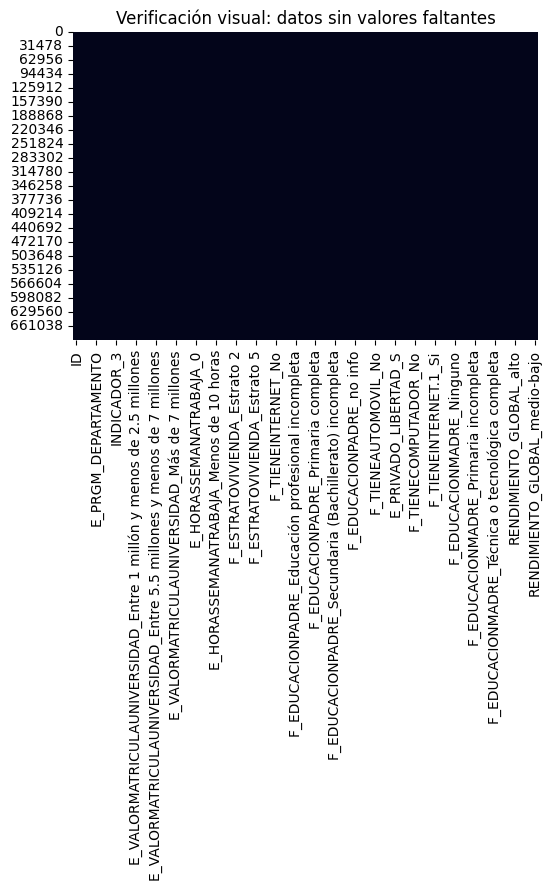

In [41]:
output_path = "train_clean.csv"
z.to_csv(output_path, index=False)

print("Archivo limpio exportado correctamente.")
print(f"Ruta de guardado: {output_path}")
print(f"Shape final: {z.shape}")
print(f"Total de columnas: {len(z.columns)}")
print(f"Valores faltantes totales: {z.isna().sum().sum()}")

df_check = pd.read_csv(output_path)
print("\nVerificación: Archivo cargado correctamente.")
print(f"Shape tras carga: {df_check.shape}")
print(f"Tipos de datos únicos:\n{df_check.dtypes.value_counts()}")

plt.figure(figsize=(6, 4))
sns.heatmap(df_check.isnull(), cbar=False)
plt.title("Verificación visual: datos sin valores faltantes")
plt.show()

